In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Nequi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Nequi


# **INSTALAR LIBRERÍAS**

In [ ]:
#!pip install libreria
!pip install pyspark
!pip install pandas

## LIBRERÍAS

In [ ]:

from pyspark.sql import SparkSession

# Sesión de Spark
spark = SparkSession.builder.appName("MalaPracticaTransaccional").getOrCreate()



### **Cargar los dataframes**

In [ ]:
# Especifica la ruta de los archivos .parquet
archivo1 = '/content/drive/MyDrive/Nequi/sample_data_0006_part_00.parquet'
#archivo2 = '/content/drive/MyDrive/Nequi/sample_data_0007_part_00.parquet'

# Cargar el primer conjunto de datos
df1 = spark.read.parquet(archivo1)

# Cargar el segundo conjunto de datos
#df2 = spark.read.parquet(archivo2)

### **Dado que los datasets son muy pesados elegí quedarme con el primero**

Modificar los tipos de datos que correspondan

In [ ]:
from pyspark.sql.functions import col, sum
from pyspark.sql.types import FloatType

# Cambiar el tipo de datos de la columna 'transaction_amount' a flotante
df1 = df1.withColumn("transaction_amount", col("transaction_amount").cast(FloatType()))
#df2 = df2.withColumn("transaction_amount", col("transaction_amount").cast(FloatType()))


### No usaré la columna subsidiary y en busca de mejorar el rendimiento la removeré

In [ ]:
df1 = df1.drop("subsidiary")

Limpiar los datos

In [ ]:
# Crear una lista de expresiones para contar valores nulos en cada columna
null_count_exprs = [sum(col(c).isNull().cast("int")).alias(c) for c in df1.columns]

# Aplicar las expresiones al DataFrame y obtener el resultado
null_counts_df1 = df1.agg(*null_count_exprs)

# Mostrar el resultado
null_counts_df1.show()

# Verificar valores nulos en el DataFrame df2
#for col_name in df2.columns:
   # null_count = df2.filter(col(col_name).isNull()).count()
   # print(f"Columna '{col_name}' tiene {null_count} valores nulos")


+-----------+---+----------------+--------------+-------+------------------+----------------+
|merchant_id|_id|transaction_date|account_number|user_id|transaction_amount|transaction_type|
+-----------+---+----------------+--------------+-------+------------------+----------------+
|          0|  0|               0|             0|      0|                 0|               0|
+-----------+---+----------------+--------------+-------+------------------+----------------+



### Nos interesa el fraccionamiento transaccional, entonces si el user_id aparece menos de cuatro veces en toda la tabla no lo consideraré.

In [ ]:


id_counts_df1 = df1.groupBy('user_id').count()
df1 = df1.join(id_counts_df1, on='user_id', how='left')
df1 = df1.filter(col('count') >= 4)
df1 = df1.drop('count')

# Contar el número de registros en df1 después del proceso
num_rows_df1_after = df1.count()

# Contar el número de registros en df2 antes del proceso
#num_rows_df2_before = df2.count()

# Realizar el proceso de contar y filtrar en df2
#id_counts_df2 = df2.groupBy('_id').count()
#df2 = df2.join(id_counts_df2, on='_id', how='left')
#df2 = df2.filter(col('count') >= 3)
#df2 = df2.drop('count')

# Contar el número de registros en df2 después del proceso
#num_rows_df2_after = df2.count()


# Mostrar el número de registros en df1  después del proceso
print(f"Número de registros en df1 después del proceso: {num_rows_df1_after}")

# Mostrar el número de registros en df2 antes y después del proceso
#print(f"Número de registros en df2 antes del proceso: {num_rows_df2_before}")
#print(f"Número de registros en df2 después del proceso: {num_rows_df2_after}")


Número de registros en df1 después del proceso: 8779400


In [ ]:
# Unir los DataFrames df1 y df2 en un nuevo DataFrame llamado 'data'
#data = df1.union(df2)

### Eliminar duplicados y verificar consistencia

In [ ]:
# Eliminar las filas duplicadas y conservar la primera aparición en df1
df1 = df1.dropDuplicates()

In [ ]:
# Filtrar las filas con 'transaction_amount' negativo en df1
negative_amount_df1 = df1.filter(col('transaction_amount') < 0)

# Contar la cantidad de valores negativos en df1
count_negative_amount_df1 = negative_amount_df1.count()

# Mostrar la cantidad de valores negativos
print(f"Cantidad de valores negativos en 'transaction_amount' en df1: {count_negative_amount_df1}")

Cantidad de valores negativos en 'transaction_amount' en df1: 0


In [ ]:
# Cuenta los valores únicos en la columna 'user_id'
unique_user_ids_count = df1.select("user_id").distinct().count()
# Muestra el resultado
print(f"El DataFrame tiene {unique_user_ids_count} valores únicos en la columna 'user_id'.")

El DataFrame tiene 661965 valores únicos en la columna 'user_id'.


In [ ]:
from pyspark.sql.functions import to_date
from pyspark.sql.window import Window

In [ ]:
# Ordenar 'df1' por la columna 'transaction_date' en su formato original
df1 = df1.orderBy(['account_number', 'transaction_date'])

In [ ]:
# Resumen estadístico de columnas numéricas en 'df1'
df1.describe(['transaction_amount']).show()

# Distribución de una columna específica en 'df1'
df1.groupBy('transaction_type').count().show()

# Resumen estadístico de fechas en 'df1'
df1.selectExpr('min(transaction_date) as min_date', 'max(transaction_date) as max_date').show()

+-------+------------------+
|summary|transaction_amount|
+-------+------------------+
|  count|           8779398|
|   mean| 192.4887944248994|
| stddev|245.07261572036188|
|    min|          5.944455|
|    max|         3210.0056|
+-------+------------------+

+----------------+-------+
|transaction_type|  count|
+----------------+-------+
|          DEBITO|7402629|
|         CREDITO|1376769|
+----------------+-------+

+-------------------+-------------------+
|           min_date|           max_date|
+-------------------+-------------------+
|2021-01-01 00:01:13|2021-11-30 23:58:41|
+-------------------+-------------------+



## Visualización de datos

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyspark
import pandas as pd

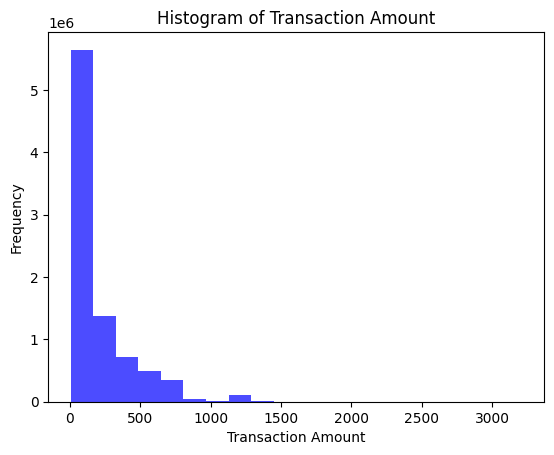

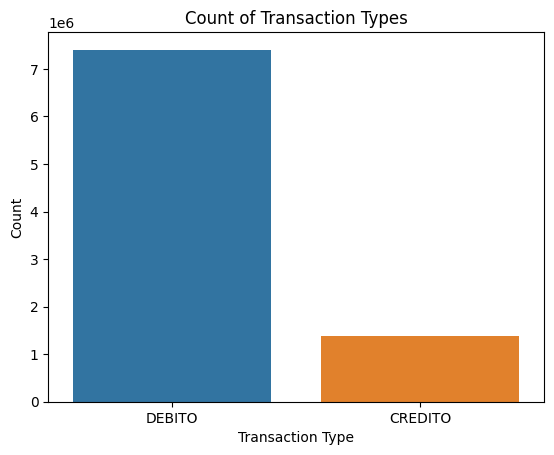

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


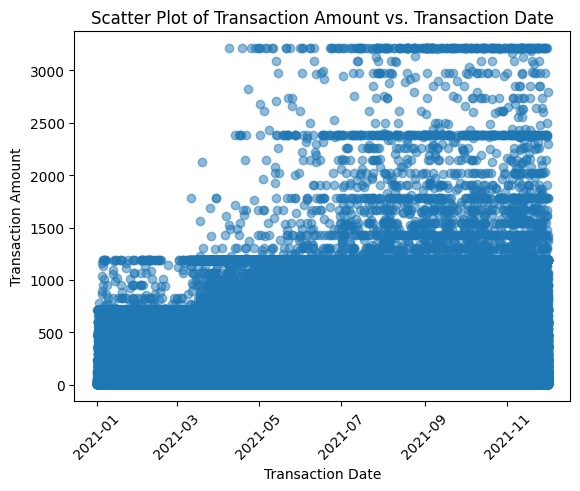

In [ ]:
# Visualización de un histograma para la columna 'transaction_amount'
transaction_amount_values = df1.select("transaction_amount").rdd.flatMap(lambda x: x).collect()

# Bins
hist_values, hist_bins = np.histogram(transaction_amount_values, bins=20)

# Visualización de un histograma
plt.hist(
    transaction_amount_values,
    bins=hist_bins,
    color='blue',
    alpha=0.7
)
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Transaction Amount')
plt.show()


# Visualización de un gráfico de barras para la columna 'transaction_type'
transaction_type_counts = df1.groupBy("transaction_type").count().toPandas()
sns.barplot(x="transaction_type", y="count", data=transaction_type_counts)
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.title('Count of Transaction Types')
plt.show()


# Visualización de un gráfico de dispersión (scatter plot) para dos columnas
# Selecciona una muestra de datos para evitar sobrecargar la visualización
df1_sample = df1.sample(False, 0.1)

# Convierte el DataFrame de Spark a un DataFrame de Pandas
df1_pandas = df1_sample.toPandas()

# Visualización de un gráfico de dispersión (scatter plot) para las columnas 'transaction_date' y 'transaction_amount'
plt.scatter(df1_pandas['transaction_date'], df1_pandas['transaction_amount'], alpha=0.5)
plt.xlabel('Transaction Date')
plt.ylabel('Transaction Amount')
plt.title('Scatter Plot of Transaction Amount vs. Transaction Date')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para una mejor visualización de fechas
plt.show()


## Valores atípicos

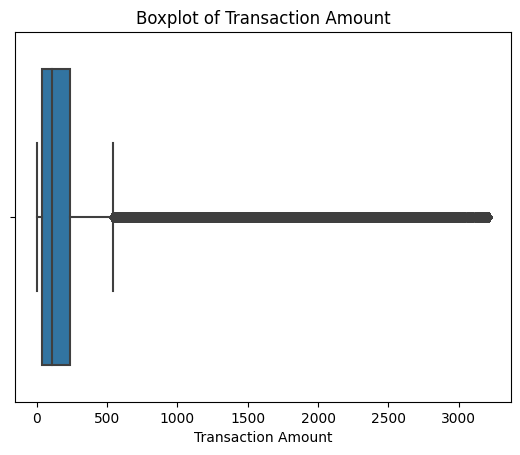

In [ ]:
# Boxplot para la variable 'transaction_amount'

df1_with_boxplot = df1.withColumn("transaction_amount_double", df1["transaction_amount"].cast("double"))

# De Spark a uno de Pandas
df1_pandas = df1_with_boxplot.select("transaction_amount_double").toPandas()

#  Boxplot para la columna 'transaction_amount_double' en Pandas
sns.boxplot(x=df1_pandas['transaction_amount_double'])
plt.xlabel('Transaction Amount')
plt.title('Boxplot of Transaction Amount')
plt.show()